In [1]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

In [2]:
from mnist import MNIST
data=MNIST(data_dir='data/MNIST/')

In [3]:
print(data.num_train)
print(data.num_val)
print(data.num_test)

55000
5000
10000


In [4]:
img_size_flat=data.img_size_flat
img_shape=data.img_shape
num_classes=data.num_classes
print(img_size_flat)
print(img_shape)
print(num_classes)

784
(28, 28)
10


In [5]:
data.y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
data.y_test_cls

array([7, 2, 1, ..., 4, 5, 6])

In [7]:
np.nonzero(data.y_test)

(array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int64),
 array([7, 2, 1, ..., 4, 5, 6], dtype=int64))

In [8]:
np.nonzero(data.y_test)[1]

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

# Plot Image

In [9]:
def plot_images(img,cls_true,cls_pred=None):
    assert(len(img)==len(cls_true)==9)
    fig,axes=plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        ax.imshow(img[i].reshape(img_shape),cmap='binary')
        if cls_pred is None:
            label='True: {0}'.format(cls_true[i])
        else:
            label='True: {0},Pred: {1}'.format(cls_true[i],cls_pred[i])
        ax.set_xlabel(label)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

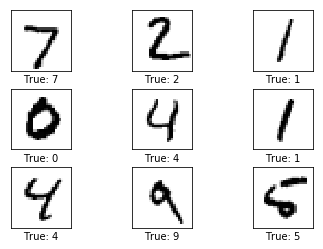

In [10]:
images=data.x_test[:9]
plot_images(img=images,cls_true=data.y_test_cls[:9])

None代表可以有**任意**數量的image,每個image都有 img_size_flat的size

In [11]:
x = tf.placeholder(tf.float32,[None,img_size_flat])

In [12]:
y_true = tf.placeholder(tf.float32,[None,num_classes])

因為 y_cls 是true的index 所有 [None] 代表接受任意張image int32,因為index

In [13]:
y_true_cls = tf.placeholder(tf.int64,[None])  

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))

In [15]:
bias = tf.Variable(tf.zeros([num_classes]))

In [16]:
logits = tf.matmul(x,weights)+bias

In [17]:
y_pred = tf.nn.softmax(logits)

axis=0 is col, axis=1 is row

In this case,logits is (num_images,num_classes)->(row,col)

we find the max one on each row

In [18]:
y_pred_cls = tf.argmax(y_pred,axis=1)

tf.nn.softmax_cross_entropy_with_logits_v2

tf.nn.softmax_cross_entropy_with_logits is DEPRECATED next version will remove

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)

In [20]:
cost = tf.reduce_mean(cross_entropy)

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [22]:
correct_prediction = tf.equal(y_true_cls,y_pred_cls)

In [23]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [24]:
session = tf.Session()

In [25]:
session.run(tf.global_variables_initializer())

In [26]:
batch_size=100

In [27]:
def sgd(num_iterations,optimizer):
    for i in range(num_iterations):
        x_batch,y_true_batch,_=data.random_batch(batch_size=batch_size)
        feed_dict_train={x:x_batch,
                        y_true:y_true_batch}
        session.run(optimizer,feed_dict=feed_dict_train)

In [28]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

A feedable iterator can be used together with tf.placeholder to select what Iterator to use in each call to tf.Session.run, via the familiar feed_dict mechanism

In [29]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [30]:
def print_confusion_matrix():
    cls_true = data.y_test_cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm,interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [31]:
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    incorrect = (correct == False)
    images = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test_cls[incorrect]
    plot_images(img=images[:9],
                cls_true=cls_true[:9],
                cls_pred=cls_pred[:9])
   

In [32]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)
            ax.set_xlabel("Weights: {0}".format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

這邊只有初始 所以她每次都預測0

In [33]:
print_accuracy()

Accuracy on test-set: 9.8%


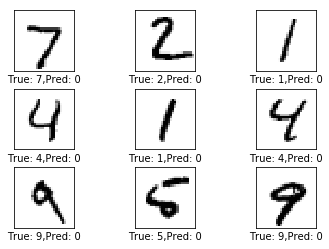

In [34]:
plot_example_errors()

Accuracy on test-set: 50.7%


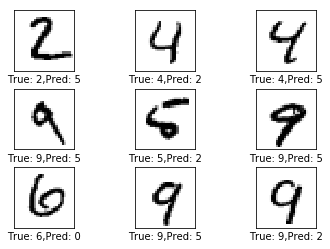

In [35]:
sgd(num_iterations=1,optimizer=optimizer)
print_accuracy()
plot_example_errors()

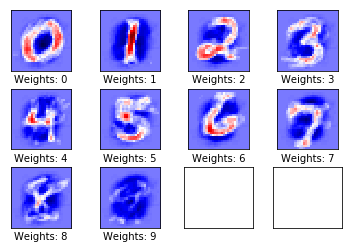

In [36]:
plot_weights()

我們已經做1遍 現在在+9

Accuracy on test-set: 75.0%


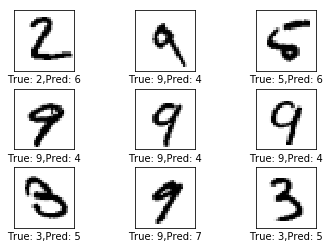

In [37]:
sgd(num_iterations=9,optimizer=optimizer)
print_accuracy()
plot_example_errors()

Accuracy on test-set: 91.7%


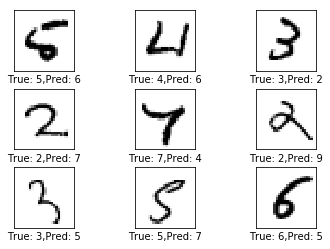

In [38]:
sgd(num_iterations=990,optimizer=optimizer)
print_accuracy()
plot_example_errors()

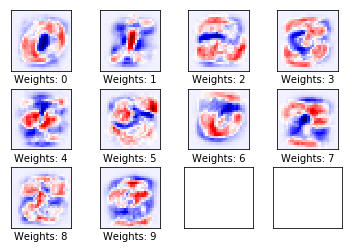

In [39]:
plot_weights()

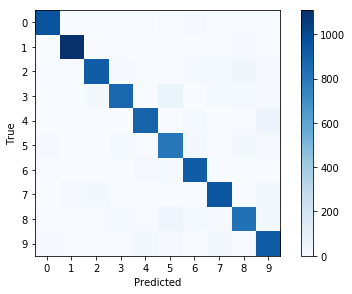

In [40]:
print_confusion_matrix()

In [41]:
#session.close()

接下來才是練習的開始
調參的時候到囉

# Learning rate

In [42]:
learning_rate=[0.1,0.5,0.9,0.95,0.99]
session.run(tf.global_variables_initializer())
for lr in learning_rate:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
    print('learning_rate is {0}'.format(lr))
    sgd(num_iterations=100,optimizer=optimizer)
    print_accuracy()
    

learning_rate is 0.1
Accuracy on test-set: 86.4%
learning_rate is 0.5
Accuracy on test-set: 89.6%
learning_rate is 0.9
Accuracy on test-set: 90.6%
learning_rate is 0.95
Accuracy on test-set: 90.6%
learning_rate is 0.99
Accuracy on test-set: 90.8%


# Optimizer

In [43]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.9).minimize(cost)
session.run(tf.global_variables_initializer())
sgd(num_iterations=1,optimizer=optimizer)
print_accuracy()
session.run(tf.global_variables_initializer())
sgd(num_iterations=1000,optimizer=optimizer)
print_accuracy()

Accuracy on test-set: 37.5%
Accuracy on test-set: 91.1%


找了超久的bug,終於搞定了

一直出現failprecondion 明顯是初始問題
```py
Adam = tf.train.AdamOptimizer().minimize(cost)
session.run(tf.global_variables_initializer())
```
初始要在使用optimizer之前

以上才是正確的

In [44]:
Adam = tf.train.AdamOptimizer(learning_rate=0.9).minimize(cost)
session.run(tf.global_variables_initializer())
sgd(num_iterations=1000,optimizer=Adam)
print_accuracy()

Accuracy on test-set: 88.6%


In [45]:
optimizer = tf.train.AdagradOptimizer(learning_rate=0.9).minimize(cost)
session.run(tf.global_variables_initializer())
sgd(num_iterations=1000,optimizer=optimizer)
print_accuracy()

Accuracy on test-set: 91.2%


# Batch-size

In [46]:
batch_size=1
session.run(tf.global_variables_initializer())
sgd(num_iterations=1000,optimizer=optimizer)
print_accuracy()
batch_size=100
session.run(tf.global_variables_initializer())
sgd(num_iterations=1000,optimizer=optimizer)
print_accuracy()
batch_size=1000
session.run(tf.global_variables_initializer())
sgd(num_iterations=1000,optimizer=optimizer)
print_accuracy()

Accuracy on test-set: 80.4%
Accuracy on test-set: 90.9%
Accuracy on test-set: 92.1%


In [47]:
#sparse_softmax_cross_entropy_with_logits

y = tf.convert_to_tensor([[0, 0, 1, 0]], dtype=tf.int64)
L = tf.convert_to_tensor([[-2.6, -1.7, 3.2, 0.1]], dtype=tf.float32)
c = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=L, labels=tf.argmax(y, 1))
with tf.Session() as sess:
    print(sess.run(c))

[0.05403664]
